In [2]:
# data analysis and wrangling
import pandas as pd
pd.set_option('display.max_columns',100)
import numpy as np
import random as rnd
import missingno as msno
from scipy.stats import zscore as zscore
import impyute
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
train_df = pd.read_csv('ml_case_training_data.csv')
hist_df = pd.read_csv('ml_case_training_hist_data.csv')
out_df = pd.read_csv('ml_case_training_output.csv')

# Data Exploration

## Output Dataset

In [4]:
out_df.head()

,id,churn
0,48ada52261e7cf58715202705a0451c9,0
1,24011ae4ebbe3035111d65fa7c15bc57,1
2,d29c2c54acc38ff3c0614d0a653813dd,0
3,764c75f661154dac3a6c254cd082ea7d,0
4,bba03439a292a1e166f80264c16191cb,0


In [5]:
out_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16096 entries, 0 to 16095
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      16096 non-null  object
 1   churn   16096 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 251.6+ KB


#### How many customers have churned?

In [6]:
print (out_df.churn.value_counts().to_string())
churned = out_df.churn.loc[out_df.churn==1].value_counts() / out_df.shape[0] * 100
stayed = out_df.churn.loc[out_df.churn==0].value_counts() / out_df.shape[0] * 100
print("Stayed ",stayed.to_string(index = False),"%")
print("Churned ",churned.to_string(index = False),"%")

0    14501
1     1595
Stayed  90.090706 %
Churned  9.909294 %


## History Dataset

In [7]:
hist_df.head()

,id,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [8]:
hist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            193002 non-null  object 
 1   price_date    193002 non-null  object 
 2   price_p1_var  191643 non-null  float64
 3   price_p2_var  191643 non-null  float64
 4   price_p3_var  191643 non-null  float64
 5   price_p1_fix  191643 non-null  float64
 6   price_p2_fix  191643 non-null  float64
 7   price_p3_fix  191643 non-null  float64
dtypes: float64(6), object(2)
memory usage: 11.8+ MB


In [9]:
hist_df.describe()

,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
count,191643.000000,191643.000000,191643.000000,191643.000000,191643.000000,191643.000000
mean,0.140991,0.054412,0.030712,43.325546,10.698201,6.455436
std,0.025117,0.050033,0.036335,5.437952,12.856046,7.782279
min,0.000000,0.000000,0.000000,-0.177779,-0.097752,-0.065172
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,0.151635,0.101780,0.072558,44.444710,24.339581,16.226389
max,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221


### **Facts**
* The avg price decreases every period

---
### **Observations**
* The minimum prices of the power is negative which doesn't make sense
* The minimum prices of the energy is zero which means maybe some customers has churned so their consumption is zero
* There is 6 features containing 1359 rows with NaN values!.

---

## Main Dataset

In [10]:
train_df.head()

,id,activity_new,campaign_disc_ele,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_first_activ,date_modif_prod,date_renewal,forecast_base_bill_ele,forecast_base_bill_year,forecast_bill_12m,forecast_cons,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max
0,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,NaN,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,NaN,2012-11-07,2015-11-09,NaN,NaN,NaN,NaN,26520.30,10025,0.0,359.29,0.095919,0.088347,58.995952,f,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000
1,24011ae4ebbe3035111d65fa7c15bc57,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,NaN,NaN,2015-06-23,NaN,NaN,NaN,NaN,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648
2,d29c2c54acc38ff3c0614d0a653813dd,NaN,NaN,NaN,4660,0,0,2009-08-21,2016-08-30,NaN,2009-08-21,2015-08-31,NaN,NaN,NaN,NaN,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800
3,764c75f661154dac3a6c254cd082ea7d,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,NaN,2010-04-16,2015-04-17,NaN,NaN,NaN,NaN,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856
4,bba03439a292a1e166f80264c16191cb,NaN,NaN,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,NaN,2010-03-30,2015-03-31,NaN,NaN,NaN,NaN,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.0,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16096 entries, 0 to 16095
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        16096 non-null  object 
 1   activity_new              6551 non-null   object 
 2   campaign_disc_ele         0 non-null      float64
 3   channel_sales             11878 non-null  object 
 4   cons_12m                  16096 non-null  int64  
 5   cons_gas_12m              16096 non-null  int64  
 6   cons_last_month           16096 non-null  int64  
 7   date_activ                16096 non-null  object 
 8   date_end                  16094 non-null  object 
 9   date_first_activ          3508 non-null   object 
 10  date_modif_prod           15939 non-null  object 
 11  date_renewal              16056 non-null  object 
 12  forecast_base_bill_ele    3508 non-null   float64
 13  forecast_base_bill_year   3508 non-null   float64
 14  foreca

In [12]:
missing_values_main_perc = train_df.isnull().mean() * 100
print('Percentage of Missing Values:\n', missing_values_main_perc)

Percentage of Missing Values:
 id                            0.000000
activity_new                 59.300447
campaign_disc_ele           100.000000
channel_sales                26.205268
cons_12m                      0.000000
cons_gas_12m                  0.000000
cons_last_month               0.000000
date_activ                    0.000000
date_end                      0.012425
date_first_activ             78.205765
date_modif_prod               0.975398
date_renewal                  0.248509
forecast_base_bill_ele       78.205765
forecast_base_bill_year      78.205765
forecast_bill_12m            78.205765
forecast_cons                78.205765
forecast_cons_12m             0.000000
forecast_cons_year            0.000000
forecast_discount_energy      0.782803
forecast_meter_rent_12m       0.000000
forecast_price_energy_p1      0.782803
forecast_price_energy_p2      0.782803
forecast_price_pow_p1         0.782803
has_gas                       0.000000
imp_cons                      0.0

In [13]:
train_df.describe()

,campaign_disc_ele,cons_12m,cons_gas_12m,cons_last_month,forecast_base_bill_ele,forecast_base_bill_year,forecast_bill_12m,forecast_cons,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max
count,0.0,1.609600e+04,1.609600e+04,1.609600e+04,3508.000000,3508.000000,3508.000000,3508.000000,16096.000000,16096.000000,15970.000000,16096.000000,15970.000000,15970.000000,15970.000000,16096.000000,16083.000000,16083.000000,16096.000000,16081.000000,16096.000000,16093.000000
mean,NaN,1.948044e+05,3.191164e+04,1.946154e+04,335.843857,335.843857,3837.441866,206.845165,2370.555949,1907.347229,0.991547,70.309945,0.135901,0.052951,43.533496,196.123447,22.462276,21.460318,1.347788,217.987028,5.030629,20.604131
std,NaN,6.795151e+05,1.775885e+05,8.235676e+04,649.406000,649.406000,5425.744327,455.634288,4035.085664,5257.364759,5.160969,79.023251,0.026252,0.048617,5.212252,494.366979,23.700883,27.917349,1.459808,366.742030,1.676101,21.772421
min,NaN,-1.252760e+05,-3.037000e+03,-9.138600e+04,-364.940000,-364.940000,-2503.480000,0.000000,-16689.260000,-85627.000000,0.000000,-242.960000,0.000000,0.000000,-0.122184,-9038.210000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000
25%,NaN,5.906250e+03,0.000000e+00,0.000000e+00,0.000000,0.000000,1158.175000,0.000000,513.230000,0.000000,0.000000,16.230000,0.115237,0.000000,40.606701,0.000000,11.960000,11.950000,1.000000,51.970000,4.000000,12.500000
50%,NaN,1.533250e+04,0.000000e+00,9.010000e+02,162.955000,162.955000,2187.230000,42.215000,1179.160000,378.000000,0.000000,19.440000,0.142881,0.086163,44.311378,44.465000,21.090000,20.970000,1.000000,119.680000,5.000000,13.856000
75%,NaN,5.022150e+04,0.000000e+00,4.127000e+03,396.185000,396.185000,4246.555000,228.117500,2692.077500,1994.250000,0.000000,131.470000,0.146348,0.098837,44.311378,218.090000,29.640000,29.640000,1.000000,275.810000,6.000000,19.800000
max,NaN,1.609711e+07,4.188440e+06,4.538720e+06,12566.080000,12566.080000,81122.630000,9682.890000,103801.930000,175375.000000,50.000000,2411.690000,0.273963,0.195975,59.444710,15042.790000,374.640000,374.640000,32.000000,24570.650000,16.000000,500.000000


### **Facts**
* The avg net marging is $217
* The avg tenure of a client is 5 years

---
### **Observations**
* The 14 columns contain negative minimum values
* The activity_new column is missing 59.3% of its data
* The campaign_disc_ele column is missing completely
* The channel_sales column is missing 26.2% of its data
* The date_end column is missing 0.01% of its data
* The date_first_activ_ column is missing 78.2% of its data
* The date_modif_prod column is missing 0.9% of its data
* The date_renewal column is missing 0.24% of it data
* The marging_gross_pow_ele and margin_net_pow_ele columns are both missing 0.08% of its data
* The net_margin column is missing 0.09% of its data
* The origin_up column is missing 0.54% of its data
* The pow_max column is missing 0.018% of its data
* The forecast_base_bill_ele, forecast_base_bill_year, forecast_bill_12m, and forecast_cons columns are each missing 78.2% of its data

---

# Data Cleaning and Imputation

## Dealing with missing data
- Convert all missing values to null values
- Analyze the amount and type of missingness in the data
- Appropriately delete or impute missing values
- Evaluate & compare the performance of the treated/imputed dataset

## History Dataset

#### Converting negative values to postive

In [14]:
negative_cols = ['price_p1_fix','price_p2_fix','price_p3_fix']

hist_df[negative_cols] = hist_df[negative_cols].apply(abs)
hist_df.describe()

,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
count,191643.000000,191643.000000,191643.000000,191643.000000,191643.000000,191643.000000
mean,0.140991,0.054412,0.030712,43.325563,10.698210,6.455443
std,0.025117,0.050033,0.036335,5.437816,12.856039,7.782273
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,0.151635,0.101780,0.072558,44.444710,24.339581,16.226389
max,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221


#### Visualizing the amount of missingness

<AxesSubplot:>

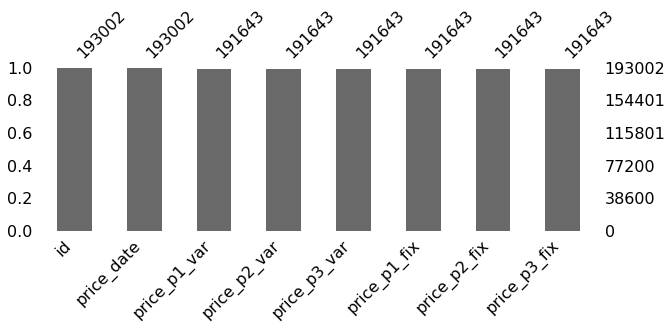

In [15]:
msno.bar(hist_df,log=False,figsize=(10,3))

- the left side of the plot represents the percentage of data completeness
- the right side of the plot representing the maximum number of rows
- the top of the plot represent the total count of the non-null values within that column
- the bottom represent the column name

#### Visualize the locations of the missing values of the dataset

<AxesSubplot:>

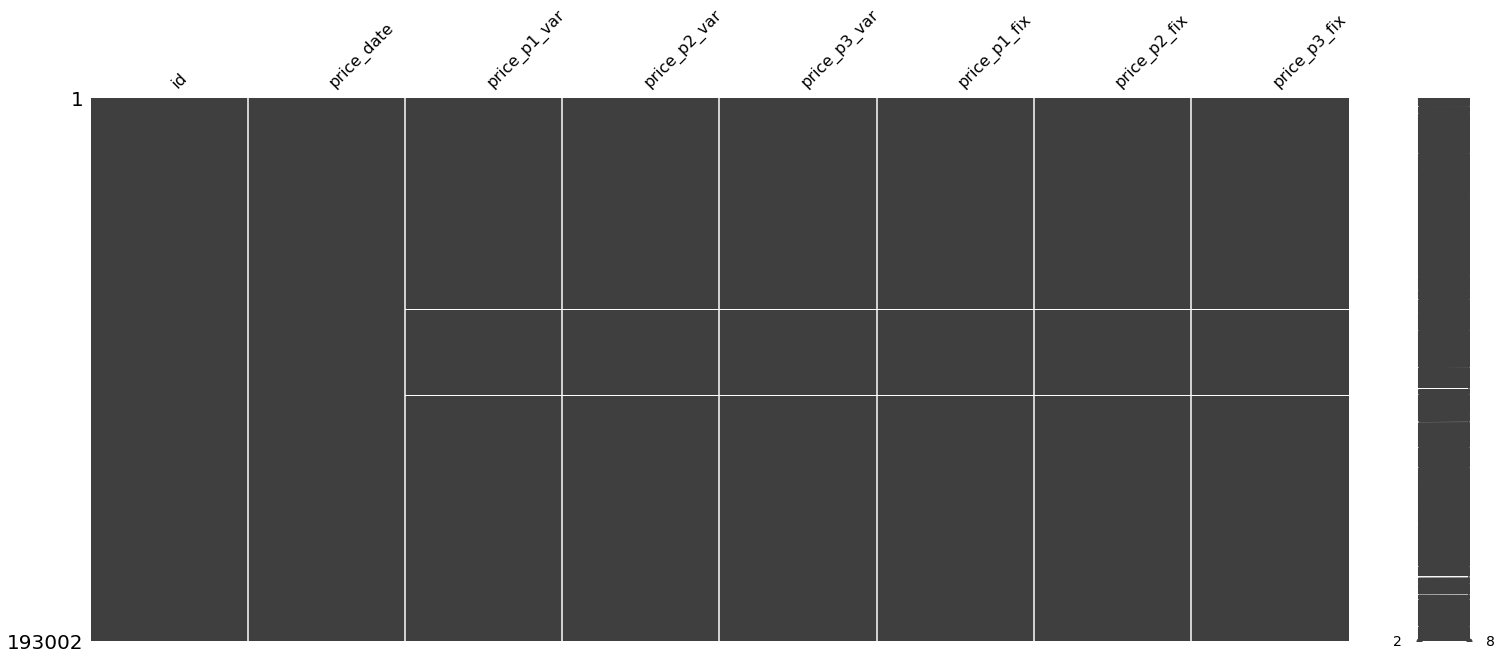

In [16]:
sorted = hist_df.sort_values(by = ['id','price_date'])
msno.matrix(sorted)

#### Visualizing the correlations of the missingness in the data

<AxesSubplot:>

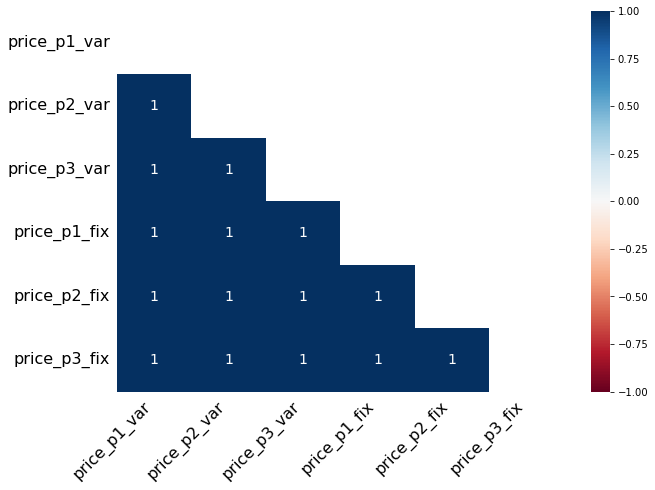

In [17]:
msno.heatmap(hist_df,figsize=(10,7))

###### Identify the index of the IDs containing missing values.

In [18]:
hist_NAN_index = hist_df[hist_df.isnull().any(axis=1)].index.values.tolist()
len(hist_NAN_index)

1359

In [19]:
hist_missing = hist_df.iloc[hist_NAN_index]
hist_missing

,id,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
75,ef716222bbd97a8bdfcbb831e3575560,2015-04-01,NaN,NaN,NaN,NaN,NaN,NaN
221,0f5231100b2febab862f8dd8eaab3f43,2015-06-01,NaN,NaN,NaN,NaN,NaN,NaN
377,2f93639de582fadfbe3e86ce1c8d8f35,2015-06-01,NaN,NaN,NaN,NaN,NaN,NaN
413,f83c1ab1ca1d1802bb1df4d72820243c,2015-06-01,NaN,NaN,NaN,NaN,NaN,NaN
461,3076c6d4a060e12a049d1700d9b09cf3,2015-06-01,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
192767,2dc2c9a9f6e6896d9a07d7bcbb9d0ce9,2015-06-01,NaN,NaN,NaN,NaN,NaN,NaN
192788,e4053a0ad6c55e4665e8e9adb9f75db5,2015-03-01,NaN,NaN,NaN,NaN,NaN,NaN
192875,1a788ca3bfb16ce443dcf7d75e702b5d,2015-06-01,NaN,NaN,NaN,NaN,NaN,NaN
192876,1a788ca3bfb16ce443dcf7d75e702b5d,2015-07-01,NaN,NaN,NaN,NaN,NaN,NaN


###### Extract the unique dates of missing data

In [20]:
date_lst = hist_missing['price_date'].unique()
id_lst = hist_missing['id'].unique()

###### Create a time dataframe with the unique dates

In [21]:
time_df = pd.DataFrame(data=date_lst, columns=['price_date'])
time_df.sort_values(by=['price_date'])

,price_date
9,2015-01-01
11,2015-02-01
8,2015-03-01
0,2015-04-01
2,2015-05-01
1,2015-06-01
10,2015-07-01
3,2015-08-01
4,2015-09-01
7,2015-10-01


### **Facts**
* There is high correlation between the missingness in the numeric columns and is values missing or non-missing
* There are 1359 clients who are missing price data at least in 1 month

---
### **Observations**
- After sorting the 'hist_df' dataset by id and price_date, we found that some columns are likely to be MNAR.
- The columns containing prices display strong positive correlation in the missingness suggests a case of MNAR.
- This event suggest that multicollinearity might be present in the dataset.
---

---
### **Imputations**
Time-series data usually comes with special characteristics such trend, seasonality and cyclicality of which we can exploit when imputing missing values in the data, but in this particular dataset, there's not such thing as seasonality because it only has monthly data for one year.

---

##### Filling Time Series Data

In [22]:
hist_df_copy = hist_df.copy(deep=True)

print(hist_df_copy.iloc[hist_NAN_index,3:9].head())

# Fill NaNs using forward fill
hist_df_copy.fillna(method = 'ffill', inplace=True)

print(hist_df_copy.iloc[hist_NAN_index,3:9].head())

     price_p2_var  price_p3_var  price_p1_fix  price_p2_fix  price_p3_fix
75            NaN           NaN           NaN           NaN           NaN
221           NaN           NaN           NaN           NaN           NaN
377           NaN           NaN           NaN           NaN           NaN
413           NaN           NaN           NaN           NaN           NaN
461           NaN           NaN           NaN           NaN           NaN
     price_p2_var  price_p3_var  price_p1_fix  price_p2_fix  price_p3_fix
75       0.000000      0.000000     44.266931      0.000000      0.000000
221      0.000000      0.000000     44.266931      0.000000      0.000000
377      0.087970      0.000000     44.266931      0.000000      0.000000
413      0.102239      0.070381     40.565969     24.339581     16.226389
461      0.000000      0.000000     44.266931      0.000000      0.000000


In [23]:
hist_df_copy.describe()

,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
count,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000
mean,0.141006,0.054376,0.030689,43.326213,10.689406,6.450494
std,0.025091,0.050040,0.036333,5.431161,12.853850,7.781323
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,0.146033,0.085450,0.000000,44.266930,0.000000,0.000000
75%,0.151635,0.101780,0.072558,44.444710,24.339581,16.226389
max,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221


###### Merge output dataset with historical forward fill dataset

In [24]:
hist_df_copy = hist_df_copy.merge(right=out_df,on=['id'])
hist_df_copy.head()

,id,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,churn
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0,0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0,0


## The Main Dataset

#### Visualizing the amount of missingness

<AxesSubplot:>

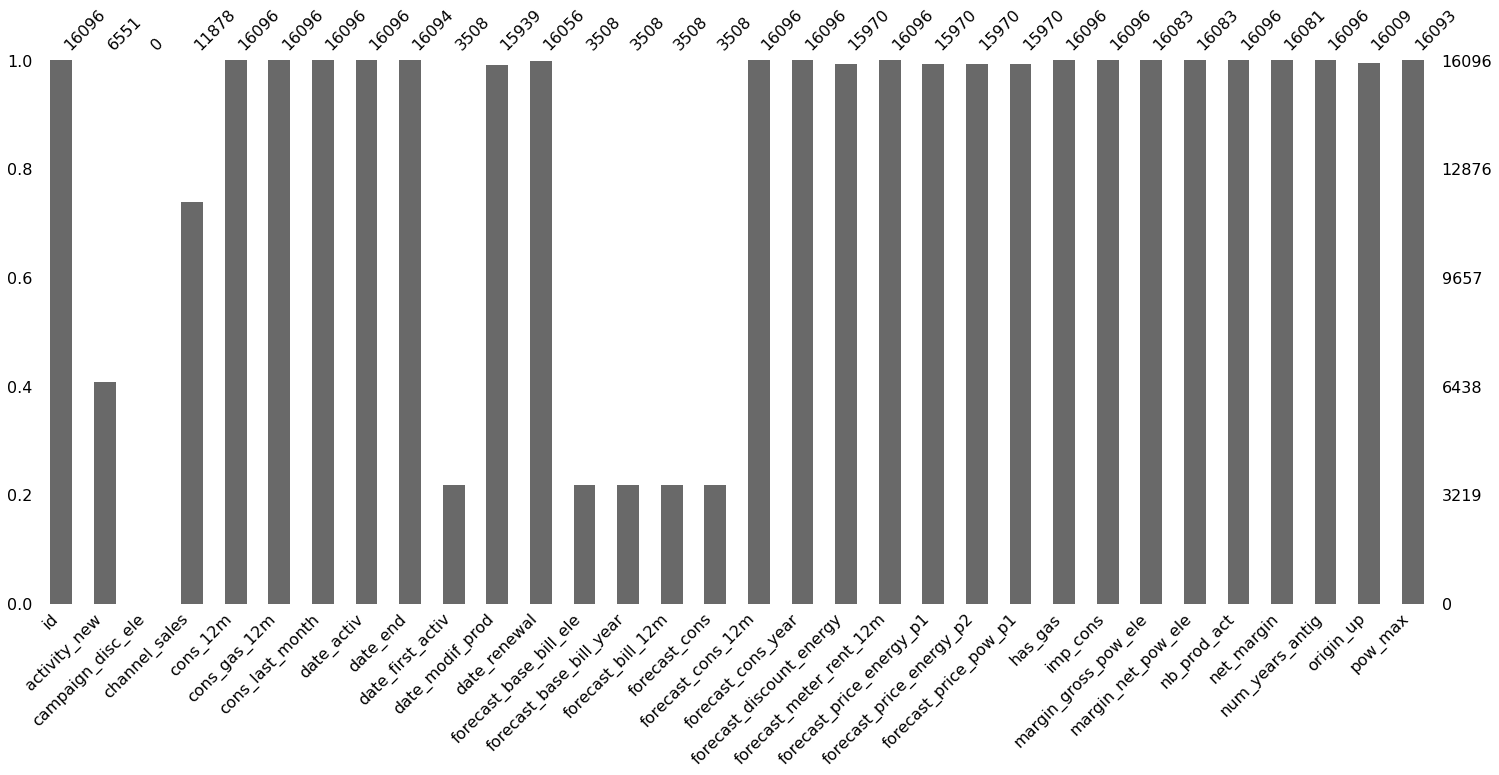

In [25]:
msno.bar(train_df)

<AxesSubplot:>

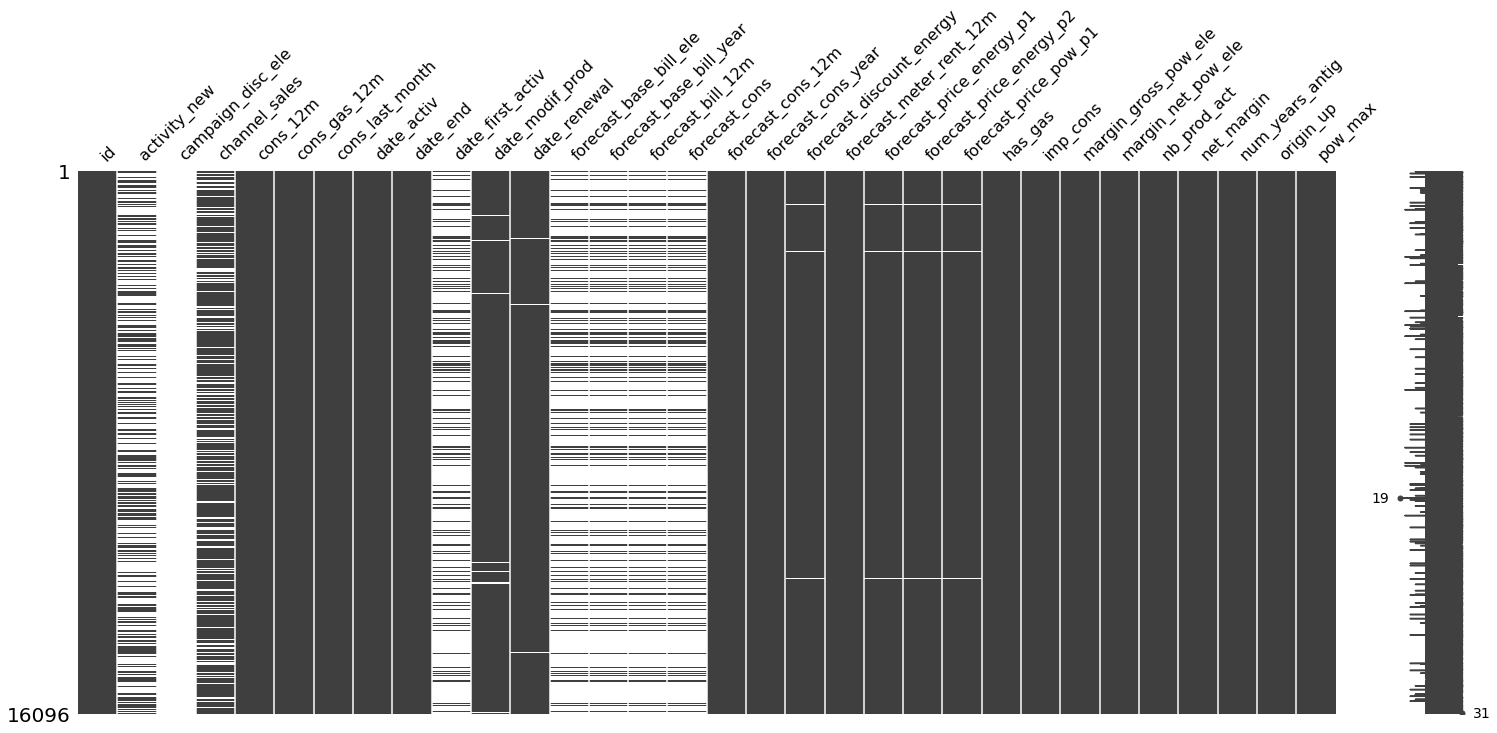

In [26]:
msno.matrix(train_df)

<AxesSubplot:>

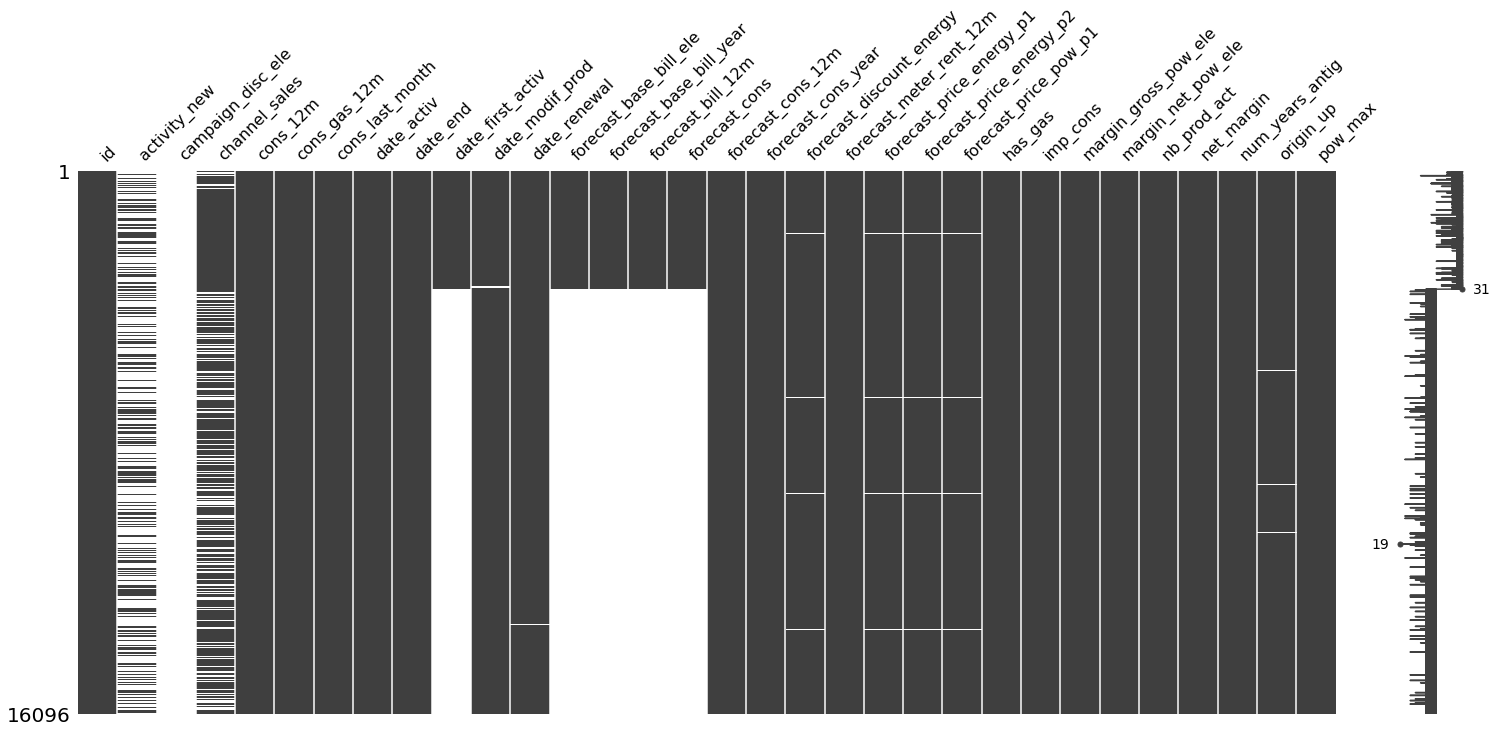

In [27]:
sorted_train = train_df.sort_values('date_first_activ')
msno.matrix(sorted_train)

<AxesSubplot:>

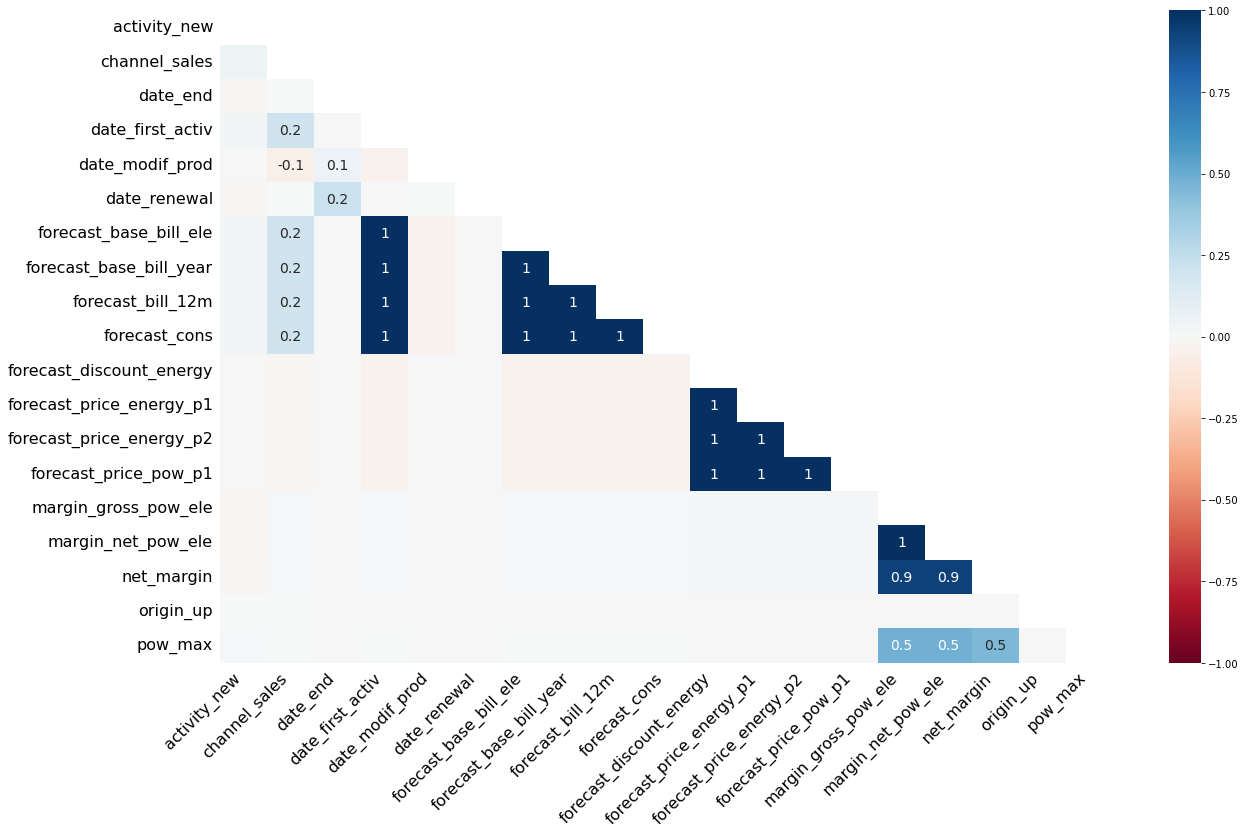

In [28]:
msno.heatmap(train_df)

In [29]:
#Test whether two objects contain the same elements
train_df.date_activ.equals(train_df.date_first_activ)

False

<AxesSubplot:>

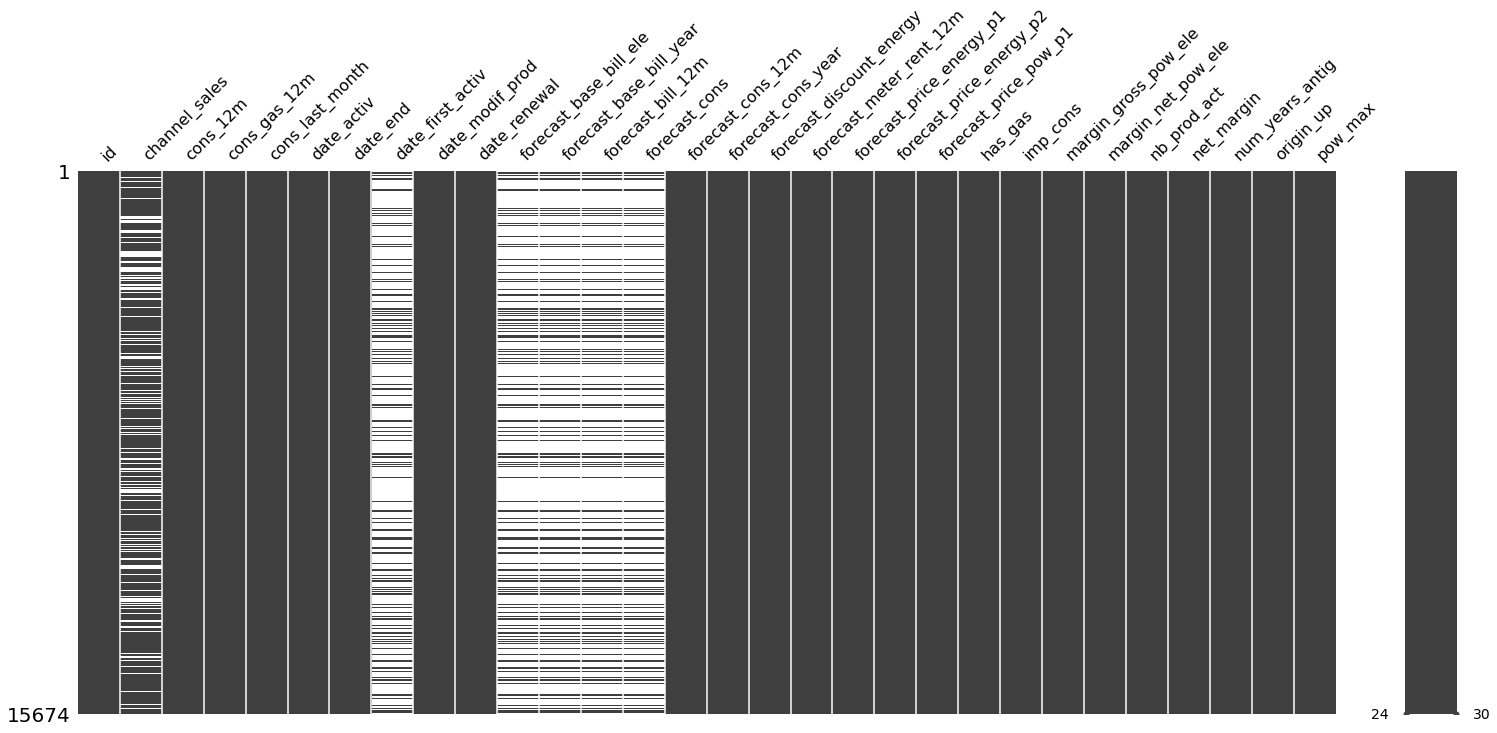

In [30]:
main_drop = train_df.drop(labels= ['activity_new','campaign_disc_ele'] , axis=1)

brush = ['date_end','date_modif_prod','date_renewal','origin_up','pow_max','margin_gross_pow_ele',
         'margin_net_pow_ele', 'net_margin','forecast_discount_energy','forecast_price_energy_p1',
         'forecast_price_energy_p2','forecast_price_pow_p1']

main_drop.dropna(subset=brush, how='any',inplace=True)

msno.matrix(main_drop)

#### Observations

- The variable activity_new is MCAR and has very low correlation with any of the variables. We can safely drop this column.
- The variable campaign_disc_elec is completely missing at random on all rows. We can get rid of this column. This suggests that subscribers are not - - subscribing through campaings offers.
- The variable date_first_activ cannot be replace by the values of the date_activ variable. MAR
- net_margin is showing strong correlation between margin_gross_pow_elec and margin_net_pow_ele. Multicollinearity is likely here.
- The variables origin_up and pow_max display no correlation with any variable and contain 0.54% and 0.01% of missingness respectively. These are MCAR and can be dropped listwise.
- Forecast_base_bill_ele, forecast_base_bill_year, forecast_bill_12m and forecast_cons variables are highly correlated with the date_first_activ variable's missingness. Accouting for 78% of missing values in the formerly mention columns and therfore are MNAR. 
- Cannot replace the date_first_activ column with the date_activ column since in some of the cases the dates are not identical.


In [31]:
# Choose the columns without missing values
incomplete_cols = ['channel_sales','date_first_activ','forecast_base_bill_ele','forecast_base_bill_year','forecast_bill_12m','forecast_cons']

complete_cols = [column_name for column_name in main_drop.columns if column_name not in incomplete_cols]

main_cc = main_drop[complete_cols]

# Fix negative numeric variables
numeric = [column_name for column_name in main_cc.columns
           if main_cc[column_name].dtype == 'float64' 
           or main_cc[column_name].dtype == 'int64']

# Overwrite positive values on negative values
main_cc[numeric] = main_cc[numeric].apply(abs)

main_cc.describe()

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max
count,1.567400e+04,1.567400e+04,1.567400e+04,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000
mean,1.916143e+05,3.132400e+04,1.941588e+04,2359.676441,1911.698354,0.976139,70.210965,0.135925,0.052858,43.522191,196.641669,23.556272,24.125235,1.348092,221.259158,5.052188,20.438270
std,6.724688e+05,1.716291e+05,8.226881e+04,3979.605687,5224.813531,5.124103,78.560454,0.026282,0.048638,5.221651,490.956048,22.456277,25.599218,1.475092,362.053657,1.670284,21.164053
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,5.893250e+03,0.000000e+00,0.000000e+00,514.045000,0.000000,0.000000,16.230000,0.115237,0.000000,40.606701,0.000000,12.360000,12.360000,1.000000,52.802500,4.000000,12.500000
50%,1.522000e+04,0.000000e+00,9.090000e+02,1178.970000,382.000000,0.000000,19.430000,0.142881,0.086163,44.311378,44.870000,21.090000,21.090000,1.000000,120.545000,5.000000,13.856000
75%,4.953825e+04,0.000000e+00,4.131500e+03,2677.220000,1994.750000,0.000000,131.500000,0.146348,0.098837,44.311378,217.962500,29.640000,29.760000,1.000000,275.797500,6.000000,19.800000
max,1.609711e+07,4.154590e+06,4.538720e+06,103801.930000,175375.000000,50.000000,2411.690000,0.273963,0.195975,59.444710,15042.790000,525.540000,615.660000,32.000000,24570.650000,16.000000,500.000000


In [32]:
# Convert the has_gas column to 0/1
main_cc['has_gas'] = main_cc['has_gas'].replace({'t':'1','f':'0'})

# Merge the main dataset with the output dataset
main_cc_merged = main_cc.merge(right=out_df,on=['id'])

# Convert the churn column to Churned/Stayed
main_cc_merged['churn'] = main_cc_merged['churn'].replace({1:'Churned',0:'Stayed'})

C:\Users\ABDELF~1\AppData\Local\Temp/ipykernel_16080/3985568441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_cc['has_gas'] = main_cc['has_gas'].replace({'t':'1','f':'0'})


In [33]:
main_cc_merged.head()

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,48ada52261e7cf58715202705a0451c9,309275,0,10025,2012-11-07,2016-11-06,2012-11-07,2015-11-09,26520.30,10025,0.0,359.29,0.095919,0.088347,58.995952,0,831.80,41.76,41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000,Stayed
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,0,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,Stayed
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,0,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,Stayed
3,bba03439a292a1e166f80264c16191cb,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,0,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,Stayed
4,568bb38a1afd7c0fc49c77b3789b59a3,121335,0,12400,2010-04-08,2016-04-08,2010-04-08,2015-04-12,10865.02,12400,0.0,170.74,0.110083,0.093746,40.606701,0,1052.37,3.18,3.18,1,823.18,6,lxidpiddsbxsbosboudacockeimpuepw,75.000,Stayed


In [34]:
# Obtain all the variables except for id
variables = [column_name for column_name in main_cc_merged.columns if column_name != 'id']

# Obtain all the categorical variables except for id
categorical = [column_name for column_name in variables if main_cc_merged[column_name].dtype == 'object']

# Obtain all the Date Variables
dates = [column_name for column_name in variables if main_cc_merged[column_name].dtype == 'datetime64[ns]']

# Obtain all the numeric columns
numeric = [column_name for column_name in variables
           if column_name not in categorical 
           and column_name != 'id'
           and column_name != 'churn'
           and column_name not in dates]

## Data Visualization

#### The Output Dataset

C:\Users\ABDELF~1\AppData\Local\Temp/ipykernel_16080/1937682855.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_tenure['z_score'] = list(abs_tenure_zscores)


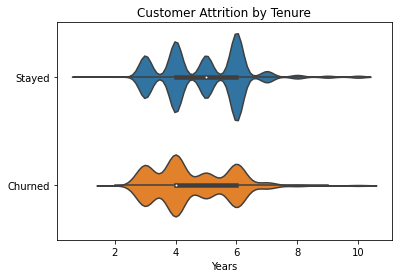

In [35]:
# Calculate the zcores of tenure
tenure_zcores = zscore(a=main_cc_merged['num_years_antig'])
# Convert to absolute values
abs_tenure_zscores = np.abs(tenure_zcores)
# Extract Columns of interest
churn_tenure = main_cc_merged[['churn','num_years_antig']]
# Add z-score column
churn_tenure['z_score'] = list(abs_tenure_zscores)
# Remove outliers 
churned_tenure_filtered = churn_tenure[churn_tenure['z_score'] < 3]
# Visualize tenure by retained customer and churner
vio = sns.violinplot( y=churned_tenure_filtered["churn"], x=churned_tenure_filtered["num_years_antig"] )
# Settings
vio.set(xlabel='Years', ylabel='')
vio.set_title("Customer Attrition by Tenure")
plt.show()

#### Facts
- The median age of churners is 4 years
- Customers are more likely to churn during the 4th year than the 7th year
- The median age of retained customers is 5 years

#### The Main Dataset

In [36]:
# Most popular electricty campaign
ele_nm = main_cc_merged.loc[(main_cc_merged['churn']>='Stayed') & (main_cc_merged['net_margin']>0),['id', 'origin_up','net_margin']]

ele_nm.value_counts(subset=['origin_up'])

origin_up                       
lxidpiddsbxsbosboudacockeimpuepw    6584
kamkkxfxxuwbdslkwifmmcsiusiuosws    4188
ldkssxwpmemidmecebumciepifcamkci    3201
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
dtype: int64

In [37]:
# Highest netting electricity subscription campaign
print(ele_nm.groupby('origin_up')['net_margin'].agg('sum').sort_values(ascending=False))

origin_up
lxidpiddsbxsbosboudacockeimpuepw    1541159.95
ldkssxwpmemidmecebumciepifcamkci     814230.02
kamkkxfxxuwbdslkwifmmcsiusiuosws     717939.95
usapbepcfoloekilkwsdiboslwaxobdp        250.40
ewxeelcelemmiwuafmddpobolfuxioce         46.22
Name: net_margin, dtype: float64


#### Facts
- The most popular electricity campaign is lxidpiddsbxsbosboudacockeimpuepw which has brought 6,584 current customers.
- The electricity campaign attributable to the highest total net margin is lxidpiddsbxsbosboudacockeimpuepw. Netting 1,541,159.95$ in 2015.


### Caveats

In [38]:
# Select current customers with positive net margins
top_customers = main_cc_merged.loc[(main_cc_merged['churn']>='Stayed') & (main_cc_merged['net_margin']>0),['id','num_years_antig','net_margin']]


top_customers.num_years_antig.value_counts()

6     4593
4     3701
5     2216
3     2210
7      557
11     210
8      155
12     113
10     101
9      100
13      11
2        6
16       1
15       1
1        1
Name: num_years_antig, dtype: int64

In [39]:
# Top 10 customers by net margin
top_customers.sort_values(by=['net_margin'],ascending=False).head(10)

,id,num_years_antig,net_margin
11502,d00e8a9951b5551d8f02e45f9ed2b0dd,3,10203.50
6930,78bd1c5c0c67f2be6de89b19df5f8861,3,5625.14
13259,818b8bca0a9d7668252d46b978169325,4,4346.37
8378,a3a739686fbd5ba8b4a21ec835507b6d,4,4305.79
324,89b3406c3ba717f1b788ceeb5af9e8b9,3,4161.74
10100,93435ecb05910c7b87e0ae9dbedb2882,4,4148.99
12028,4519e6a8928a015819466fc9de0fa49e,3,4040.60
6405,933527d7a2f669af49075a2380c10ded,4,3744.72
6850,43580ef6cc40fcfd0a9b76eee17a267a,4,3716.78
13553,ee98a86efa759681cc59c7d4e0d0312f,4,3407.65


These are the most profitable customers for PowerCo in terms of net margin. Beware most of them are within the likely tenure of attrition. Time for a marketing campaign!

In [43]:
hist_df_copy.to_csv('hist_updated.csv')

main_cc_merged.to_csv('main_updated.csv')

# Refrences

#### I got a lot of help from this notebook written by "Lucas Garces"
"https://github.com/srgarcess/BCG/blob/main/task2/EDA_Cleaning_BCG.ipynb"